# Unity y ML-Agents para la creación de agentes inteligentes en videojuegos mediante Deep Q-Learning.

### Introcucción
**Unity** fue diseñado como un motor de juegos, es decir, un software especializado en la creación de videojuegos, pero con el tiempo Unity se fue actualizando y actualmente es el segundo motor de juegos más utilizado solo superado por el UnrealEngine de EpicGames. Sin embargo el objetivo inicial de ser un motor de videojuegos a cambiado bastante hasta convertirse más en un entorno de simulación.

Unity tiene características que le permiten resaltar sobre los demás como un motor de físicas avanzado, capacidad para manejar gráficos en 2D y 3D, compatibilidad con la mayoría de plataformas tecnológicas que van desde sistemas de dispositivos mobiles (Android, IOS), hasta dispositivos de realidad aumentada y realidad virtual (Oculus Rift, Microsoft HoloLens, etc.), en total es compatible con 25 plataformas. También cuenta con una interfaz sencilla de utilizar y el lenguaje de programación principal es C# aunque recientemente liberaron una forma de programación visual para usuarios menos experimentados y la capacidad de usar Python.

**The Unity Machine Learning Agents Toolkit** (ML-Agents) es un proyecto open-source que le permite a juegos y simulaciones dentro de Unity servir como environments para el entrenamiento de agentes inteligentes. ML-Agents permite a los desarrolladores utilizar los últimos algoritmos (basados en Pytorch) para el entrenamiento de agentes inteligentes, para 2D, 3D y VR/AR. 

ML-Agents también cuenta con una API de Python para que los investigadores puedan usar Reinforcement Learning, Imitation Learning, Neuroevolution o cualquier otro método que quieran. Esto es beneficioso tanto para los desarrolladores de juegos que pueden crear mejor IA de una manera más sencilla, así como para los investigadores que tienen en sus manos un motor de simulación bastante avanzado y genérico.

### Objetivo
En este proyecto se revisará como conectar Python y Unity para entrenar a una agente cuya tarea será moverse a través de un circuito de carreras como lo haría una IA de un juego real mediante Deep Q-Learning.

# 1. Primeros pasos con Unity y ML-Agents.

## 1.1 Importar dependencias.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import random
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.environment import ActionTuple, BaseEnv
from typing import Tuple
from typing import NamedTuple, List
from typing import Dict
from math import floor

## 1.2 Conectar ML-Agents Env con Unity.
Usamos la función ``UnityEnvironment`` para crear un nuevo environment y conectarlo con Unity.  
Mientras la celda esta siendo procesada se debe iniciar la simulación en Unity (playmode).

In [2]:
env = UnityEnvironment(file_name = None, base_port=5004)

In [3]:
env.reset()

## 1.3 Obtener la información del agente.
Revisamos la información del agente, primero revisamos el nombre del comportamiento asignado y las específicaciones de ese comportamiento.

In [4]:
# Nombre del primer comportamiento.
behavior_name = list(env.behavior_specs)[0]
print(f"Behavior name: {behavior_name} \n")

# Específicaciones del comportamiento.
spec = env.behavior_specs[behavior_name]
print(spec.observation_specs)

# Número de observaciones.
print(f"\nNúmer of observations: {len(spec.observation_specs)}")

# ¿Hay una observación visual?
vis_obs = any(len(spec.shape) == 3 for spec in spec.observation_specs)
print(f"\nVisual observation: {vis_obs}")

# ¿La acción es continua o multi discreta?
if spec.action_spec.continuous_size > 0:
    print(f"\nThere are {spec.action_spec.continuous_size} continuous actions.")
if spec.action_spec.is_discrete():
    print(f"\nThere are {spec.action_spec.discrete_size} discrete actions.")

Behavior name: CarAI?team=0 

[ObservationSpec(shape=(84, 84, 4), dimension_property=(<DimensionProperty.UNSPECIFIED: 0>, <DimensionProperty.UNSPECIFIED: 0>, <DimensionProperty.UNSPECIFIED: 0>), observation_type=<ObservationType.DEFAULT: 0>, name='StackingSensor_size4_CameraSensor')]

Númer of observations: 1

Visual observation: True

There are 1 discrete actions.


## 1.4 Steps.
Obtenemos los steps de decisión y los terminales. Los steps contienen información sobre las observaciones y las rewards del agente. Establecemos las acciones en env para todos los agentes en la simulación para el siguiente step específicando el nombre del comportamiento y las acciones.

In [5]:
decision_steps, terminal_steps = env.get_steps(behavior_name)
env.set_actions(behavior_name, spec.action_spec.empty_action(len(decision_steps)))

In [6]:
env.step()

### 1.5 La primera observación visual.

Here is the first visual observation.
(84, 84, 4)


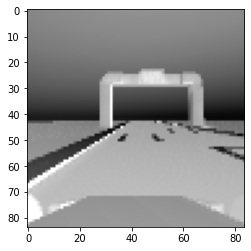

In [7]:
%matplotlib inline

for index, obs_spec in enumerate(spec.observation_specs):
  if len(obs_spec.shape) == 3:
    print("Here is the first visual observation.")
    print(decision_steps.obs[index][0,:,:,:].shape)
    plt.imshow(decision_steps.obs[index][0,:,:,:])
    plt.show()

for index, obs_spec in enumerate(spec.observation_specs):
  if len(obs_spec.shape) == 1:
    print(f"First vector observations: {decision_steps.obs[index][0,:]}")

### 1.6 Probar el seguimeinto de los agentes.


In [8]:
for episode in range(3):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    
    # -1 Sin seguimiento.
    tracked_agent = -1 # -1 not yet tracking
    
    # Para el agente en segimiento.
    done = False
    episode_rewards = 0
    
    while not done:
        # Seguimiento del primer agente si este no esta en seguimiento.
        # Nota : len(decision_steps) = [number of agents that requested]
        if tracked_agent == -1 and len(decision_steps) >= 1:
            tracked_agent = decision_steps.agent_id[0]
        
        # Generar las acciones para todos los agentes.
        action = spec.action_spec.random_action(len(decision_steps))
        
        # Establecer las acciones.
        env.set_actions(behavior_name, action)
        
        # Movemos la simulación al siguiente step.
        env.step()
        
        #Recopilar los resultados de la simulación.
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        
        # El agente solicitó una decisión.
        if tracked_agent in decision_steps:
            episode_rewards += decision_steps[tracked_agent].reward
        if tracked_agent in terminal_steps:
            episode_rewards += terminal_steps[tracked_agent].reward
            done = True
    
    # Se imprimen los resultados del episodio.
    print(f"Total rewards for episode {episode} is {episode_rewards}.")
    
# Se cierra en environment.
env.close()
print("Closed environment.")

Total rewards for episode 0 is -5.0.
Total rewards for episode 1 is -4.0.
Total rewards for episode 2 is -3.0.
Closed environment.


# 2. Modelo, experiencia y entrenamiento.

## 2.1 Definición del Modelo.
Primero definimos definimos el modelo ``VisuaQNetwork`` que usaremos para el entrenamiento del agente.  
La entrada del modelo será un tensor tridimensional (84,84,4) porque recibirá r stacks de imagenes de 84x84 pixeles.  
La salida del modelo será un tensor unidimensional porque solo hay un branch de acciones posibles (3).

In [9]:
class VisualQNetwork(torch.nn.Module):
    def __init__(
        self,
        input_shape: Tuple[int, int, int], 
        encoding_size: int, 
        output_size: int
    ):
        """
        Crea una red neuronal que toma como input un batch de imagenes 
        (tensor tridimensional) y da como salida un batch de outputs 
        (tensor unidimensional).
        """
        super(VisualQNetwork, self).__init__()
        height = input_shape[0]
        width = input_shape[1]
        initial_channels = input_shape[2]
        conv_1_hw = self.conv_output_shape((height, width), 8, 4)
        conv_2_hw = self.conv_output_shape(conv_1_hw, 4, 2)
        self.final_flat = conv_2_hw[0] * conv_2_hw[1] * 32
        self.conv1 = torch.nn.Conv2d(initial_channels, 16, [8, 8], [4, 4])
        self.conv2 = torch.nn.Conv2d(16, 32, [4, 4], [2, 2])
        self.dense1 = torch.nn.Linear(self.final_flat, encoding_size)
        self.dense2 = torch.nn.Linear(encoding_size, output_size)

    def forward(self, visual_obs: torch.tensor):
        visual_obs = visual_obs.permute(0, 3, 1, 2)
        conv_1 = torch.relu(self.conv1(visual_obs))
        conv_2 = torch.relu(self.conv2(conv_1))
        hidden = self.dense1(conv_2.reshape([-1, self.final_flat]))
        hidden = torch.relu(hidden)
        hidden = self.dense2(hidden)
        return hidden

    @staticmethod
    def conv_output_shape(
        h_w: Tuple[int, int],
        kernel_size: int = 1,
        stride: int = 1,
        pad: int = 0,
        dilation: int = 1,
        ):
            """
            Calcula la altura y el ancho de la salida de una convolution layer.
            """
            h = floor(
              ((h_w[0] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
            )
            w = floor(
              ((h_w[1] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
            )
            return h, w

## 2.2 Definición de Experiencia
Definimos una experiencia como un contenedor de los datos de transición de un agente.  
Contiene: observación, acción, recompensa, una bandera de 'hecho' y la siguiente observación.

In [10]:
class Experience(NamedTuple):
    """
    Una experiencia contiene los datos de la transición de un agente.
        -Observation
        -Action
        -Reward
        -Done flag
        -Next Observation
    """
    
    obs: np.ndarray
    action: np.ndarray
    reward: float
    done: bool
    next_obs: np.ndarray

# Una trayectoria es una secuencia ordenada de experiencias.
Trajectory = List[Experience]

# Un búfer es una lista desordenada de experiencias de múltiples trayectorias.
Buffer = List[Experience]

## 2.3 Definición del entrenamiento

In [24]:
class Trainer:
    @staticmethod
    def generate_trajectories(
        env: BaseEnv, q_net: VisualQNetwork, buffer_size: int, epsilon: float
    ):
        """
        Dado un Unity Environment y una Q-Network, este método generará un búfer de 
        Experiencias obtenidas al ejecutar el Environment con la Policy derivada de 
        la Q-Network.
        :param BaseEnv: El UnityEnvironment usado.
        :param q_net: La Q-Network usada para recolectar la data.
        :param buffer_size: El tamaño mínimo del buffer que devolverá este método.
        :param epsilon: Agregará una variable normal aleatoria con desviación estándar.
        epsilon a los valores de la Q-Network para fomentar la exploración.
        :returns: una Tuple que contiene el búfer creado y el promedio acumulado de los 
        agentes obtenidos.
        """
        # Crear un buffer vacio.
        buffer: Buffer = []

        # Reiniciar el environment.
        env.reset()
        # Leer y guardar el nombre del comportamiento del env.
        behavior_name = list(env.behavior_specs)[0]
        # Leer y guardar las específicaciones del comportamiento del env.
        spec = env.behavior_specs[behavior_name]

        # Mapping AgentID -> trajectories. Ayuda a crear trayectorias para cada agente.
        dict_trajectories_from_agent: Dict[int, Trajectory] = {}
        # Mapping AgentId -> "last observation".
        dict_last_obs_from_agent: Dict[int, np.ndarray] = {}
        # Mapping AgentId -> "last action".
        dict_last_action_from_agent: Dict[int, np.ndarray] = {}
        # Mapping AgentId -> cumulative reward (Solo para reporte).
        dict_cumulative_reward_from_agent: Dict[int, float] = {}
        # Lista que guarda las recompensas acumuladas hasta el momento.
        cumulative_rewards: List[float] = []

        # Mientras no exista suficiente data en el buffer.
        while len(buffer) < buffer_size:
            # Obtener los Decision Steps y Terminal Steps del agente.
            decision_steps, terminal_steps = env.get_steps(behavior_name)

            # Para todos los agentes con un Terminal Step:
            for agent_id_terminated in terminal_steps:
                # Se crea la última experiencia.
                last_experience = Experience(
                      obs=dict_last_obs_from_agent[agent_id_terminated].copy(),
                      reward=terminal_steps[agent_id_terminated].reward,
                      done=not terminal_steps[agent_id_terminated].interrupted,
                      action=dict_last_action_from_agent[agent_id_terminated].copy(),
                      next_obs=terminal_steps[agent_id_terminated].obs[0],
                )
                # Se limpia la última observación y la última acción. (La trayectoria termino).
                dict_last_obs_from_agent.pop(agent_id_terminated)
                dict_last_action_from_agent.pop(agent_id_terminated)
                # Se reporta la recompensa acumulada.
                cumulative_reward = (
                  dict_cumulative_reward_from_agent.pop(agent_id_terminated)
                  + terminal_steps[agent_id_terminated].reward
                )
                cumulative_rewards.append(cumulative_reward)
                # Se añade la Trayectoria y la última experiencia al buffer.
                buffer.extend(dict_trajectories_from_agent.pop(agent_id_terminated))
                buffer.append(last_experience)

            # Para todos los agentes con Decision Step:
            for agent_id_decisions in decision_steps:
                # Si el agente no tiene una trayectoria, se crea una vacia.
                if agent_id_decisions not in dict_trajectories_from_agent:
                    dict_trajectories_from_agent[agent_id_decisions] = []
                    dict_cumulative_reward_from_agent[agent_id_decisions] = 0

                # Si el agente solicita una decisión con la última observación
                if agent_id_decisions in dict_last_obs_from_agent:
                    # Se crea una experiencia de la última observación y el Decision Step.
                    exp = Experience(
                        obs=dict_last_obs_from_agent[agent_id_decisions].copy(),
                        reward=decision_steps[agent_id_decisions].reward,
                        done=False,
                        action=dict_last_action_from_agent[agent_id_decisions].copy(),
                        next_obs=decision_steps[agent_id_decisions].obs[0],
                    )
                    # Se actualiza la trayectoria del agente y su recompensa acumulada.
                    dict_trajectories_from_agent[agent_id_decisions].append(exp)
                    dict_cumulative_reward_from_agent[agent_id_decisions] += (
                        decision_steps[agent_id_decisions].reward
                    )
                # Guarda la observación como la nueva última observación.
                dict_last_obs_from_agent[agent_id_decisions] = (
                  decision_steps[agent_id_decisions].obs[0]
                )

            # Se genera una acción para cada agente que solicit una decisión.
            # Se calculan los valores para cada acción dada la observación.
            actions_values = (
                q_net(torch.from_numpy(decision_steps.obs[0])).detach().numpy()
            )
            # Se añade algo de ruido epsilon a los valores.
            actions_values += epsilon * (
                np.random.randn(actions_values.shape[0], actions_values.shape[1])
            ).astype(np.float32)
            # Selecciona la mejor acción usando argmax.
            actions = np.argmax(actions_values, axis=1)
            actions.resize((len(decision_steps), 1))
            # Guarda la acción, se pondrá en una trayectoría después.
            for agent_index, agent_id in enumerate(decision_steps.agent_id):
                dict_last_action_from_agent[agent_id] = actions[agent_index]

            # Se establecen las acciones del environment.
            # Los Unity Environments esperan instancias del tipo ActionTuple.
            action_tuple = ActionTuple()
            action_tuple.add_discrete(actions)
            env.set_actions(behavior_name, action_tuple)
            # Se realiza un paso en la simulación.
            env.step()
        return buffer, np.mean(cumulative_rewards)
        
    @staticmethod
    def update_q_net(
        q_net: VisualQNetwork, 
        optimizer: torch.optim, 
        buffer: Buffer, 
        action_size: int
    ):
        """
        Realiza una actualización de Q-Network utilizando el optimizador y el búfer proporcionados
        """
        BATCH_SIZE = 1000
        NUM_EPOCH = 3
        GAMMA = 0.9
        batch_size = min(len(buffer), BATCH_SIZE)
        random.shuffle(buffer)
        # Se separa el buffer en batches.
        batches = [
          buffer[batch_size * start : batch_size * (start + 1)]
          for start in range(int(len(buffer) / batch_size))
        ]
        for _ in range(NUM_EPOCH):
            for batch in batches:
                # Create the Tensors that will be fed in the network
                obs = torch.from_numpy(np.stack([ex.obs for ex in batch]))
                reward = torch.from_numpy(
                  np.array([ex.reward for ex in batch], dtype=np.float32).reshape(-1, 1)
                )
                done = torch.from_numpy(
                  np.array([ex.done for ex in batch], dtype=np.float32).reshape(-1, 1)
                )
                action = torch.from_numpy(np.stack([ex.action for ex in batch]))
                next_obs = torch.from_numpy(np.stack([ex.next_obs for ex in batch]))

                # Use the Bellman equation to update the Q-Network
                target = (
                  reward
                  + (1.0 - done)
                  * GAMMA
                  * torch.max(q_net(next_obs).detach(), dim=1, keepdim=True).values
                )
                mask = torch.zeros((len(batch), action_size))
                mask.scatter_(1, action, 1)
                prediction = torch.sum(qnet(obs) * mask, dim=1, keepdim=True)
                criterion = torch.nn.MSELoss()
                loss = criterion(prediction, target)

                # Perform the backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

# 3. Entrenamiento y resultados

Ahora usamos todo lo anterior para crear un nuevo environment, conectarlo con Unity y después entrenamos al agente usando la red neuronal definida arriba. 

Environment created
Training step 1 	reward -5.0
Training step 2 	reward -5.0
Training step 3 	reward -4.75
Training step 4 	reward -3.5
Training step 5 	reward -4.25
Closed environment.


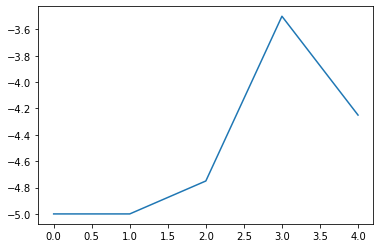

In [25]:
# Cierra un env si no ha sido cerrado antes.
try:
    env.close()
except:
    pass

env = UnityEnvironment(file_name = None, base_port=5004)
print("Environment created")

# Se crea una Q-Network.
qnet_input = (84,84,4)
qnet_output = 3
qnet_encoding_size = 126
qnet = VisualQNetwork(qnet_input, qnet_encoding_size, qnet_output)

# Se crea un bufer para las experiencias.
experiences: Buffer = []
    
# Se define el optimizador (Adam).
optim = torch.optim.Adam(qnet.parameters(), lr= 0.001)

# Contenedor para las recompensas acumuladas.
cumulative_rewards: List[float] = []

# Se definen el número de steps a realizar (70).
NUM_TRAINING_STEPS = 5

# Se define el número de experiencias a recolectar en cada step de entrenamiento.
NUM_NEW_EXP = 1000

# Se define el tamaño máximo del buffer.
BUFFER_SIZE = 10000

for n in range(NUM_TRAINING_STEPS):
    new_exp,_ = Trainer.generate_trajectories(env, qnet, NUM_NEW_EXP, epsilon = 0.1)
    random.shuffle(experiences)
    if len(experiences) > BUFFER_SIZE:
        experiences = experiences[:BUFFER_SIZE]
    experiences.extend(new_exp)
    Trainer.update_q_net(qnet, optim, experiences, 3)
    _, rewards = Trainer.generate_trajectories(env, qnet, 100, epsilon = 0)
    cumulative_rewards.append(rewards)
    print("Training step", n+1, "\treward", rewards)
    
env.close()
print("Closed environment.")

# Muestra el gráfico de entrenamiento.
plt.plot(range(NUM_TRAINING_STEPS), cumulative_rewards)

# 4. Exportar el modelo

In [27]:
qnet.eval()

PATH = "car_qnet_model.pt"
torch.save(qnet.state_dict(), PATH)